In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import typing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm.notebook import tqdm

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [4]:
data_dir = "Cell_Phones_and_Accessories_5.json"
df = pd.read_json(data_dir, lines=True)
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

In [6]:
# Remove duplicate values
df = df.astype(str)
duplicates = df.duplicated()
print("Number of duplicate values:", duplicates.sum())

Number of duplicate values: 0


In [7]:
# Drop unnecessary columns
df = df.drop(['reviewerID'], axis=1)
df = df.drop(['asin'], axis=1)
df = df.drop(['reviewerName'], axis=1)
df = df.drop(['helpful'], axis=1)
df = df.drop(['summary'], axis=1)
df = df.drop(['unixReviewTime'], axis=1)
df = df.drop(['reviewTime'], axis=1)
df.head(5)

,reviewText,overall
0,They look good and stick good! I just don't li...,4
1,These stickers work like the review says they ...,5
2,These are awesome and make my phone look so st...,5
3,Item arrived in great time and was in perfect ...,4
4,"awesome! stays on, and looks great. can be use...",5


In [8]:
def get_sentiment(text:str, analyser,desired_type:str='pos'):
    sentiment_score = analyser.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Sentiment scores
def get_sentiment_scores(df, data_column):
    # Initialize sentiment analyzer
    sid_analyzer = SentimentIntensityAnalyzer()
    
    # Initialize progress bar
    pbar = tqdm(total=len(df), desc='Processing', dynamic_ncols=True)
    
    # Initialize new columns
    df[f'{data_column} Positive Sentiment Score'] = 0.0
    df[f'{data_column} Negative Sentiment Score'] = 0.0
    df[f'{data_column} Neutral Sentiment Score'] = 0.0
    df[f'{data_column} Compound Sentiment Score'] = 0.0
    
    # Calculate sentiment scores for each row
    for i in range(len(df)):
        text = df.loc[i, data_column]
        sentiment_score = sid_analyzer.polarity_scores(str(text))
        
        df.loc[i, f'{data_column} Positive Sentiment Score'] = sentiment_score['pos']
        df.loc[i, f'{data_column} Negative Sentiment Score'] = sentiment_score['neg']
        df.loc[i, f'{data_column} Neutral Sentiment Score'] = sentiment_score['neu']
        df.loc[i, f'{data_column} Compound Sentiment Score'] = sentiment_score['compound']
        
        # Update progress bar
        pbar.update()
    
    # Close progress bar
    pbar.close()
    
    return df

In [9]:
text_sentiment = get_sentiment_scores(df,'reviewText')
display(text_sentiment.sample(5))

Processing:   0%|                                                                           | 0/194439 [00:00<…

,reviewText,overall,reviewText Positive Sentiment Score,reviewText Negative Sentiment Score,reviewText Neutral Sentiment Score,reviewText Compound Sentiment Score
54716,I got these to use while skiing when I would h...,3,0.118,0.094,0.788,0.5101
110850,Highly recommended for anyone going to a theme...,5,0.039,0.041,0.919,-0.0276
19764,i really love this car charger ! its super che...,5,0.332,0.027,0.641,0.9492
5874,A car charger is a must for anyone who has a c...,5,0.000,0.133,0.867,-0.6486
78847,I bought this case for my daughter and she rea...,4,0.091,0.017,0.892,0.7061


In [10]:
sentiment_data = text_sentiment[['reviewText', 'reviewText Positive Sentiment Score', 'reviewText Negative Sentiment Score', 'reviewText Neutral Sentiment Score']].copy()

sentiment_data.columns = ['reviewText', 'pos', 'neg', 'neu']

sentiment_data['overall'] = text_sentiment['overall']

sentiment_data['overall'] = sentiment_data['overall'].apply(lambda x: int(x) - 1)

#sentiment_data['overall'] = sentiment_data['overall'].apply(lambda x: 0 if x <= 3 else 1)

display(sentiment_data.head())

,reviewText,pos,neg,neu,overall
0,They look good and stick good! I just don't li...,0.188,0.112,0.700,3
1,These stickers work like the review says they ...,0.368,0.000,0.632,4
2,These are awesome and make my phone look so st...,0.226,0.000,0.774,4
3,Item arrived in great time and was in perfect ...,0.289,0.000,0.711,3
4,"awesome! stays on, and looks great. can be use...",0.357,0.000,0.643,4


In [11]:
pd.set_option('display.max_colwidth', None)
display(text_sentiment.sample(5))

,reviewText,overall,reviewText Positive Sentiment Score,reviewText Negative Sentiment Score,reviewText Neutral Sentiment Score,reviewText Compound Sentiment Score
162721,"Igot this for my wife. She loves it with two exceptions: 1. She has a hard time using the handset unless she takes it out of the case, turns on the speaker or uses bluetooth. 2. The picture shows 2 styluii, she only got the small one pictured. Other than that, the case is nicely constructed and had a feel of quality.",4,0.099,0.021,0.881,0.7351
172346,it keeps the good looks of the iphone 5s. it has a good grip and good protection on the edges.,5,0.339,0.000,0.661,0.8271
86367,"I have noticed a considerable amount of improvement from my older charger in terms of charging speed, great product and accurate description",5,0.269,0.000,0.731,0.8107
119765,The best thing about the iPhone 5 is how slim and sleek it is. This case allows you to retain those qualities with adding a nice level of protection and at a very reasonable cost. I have two of these cases (two different colors) and both fit perfectly and I'd easily recommend these to friends.,5,0.311,0.000,0.689,0.9670
110875,Easy to lock and unlock with no moist or condensation. Plastic cover is nice and clear with good visual and operate in. Durable and accessible without complications.,5,0.316,0.062,0.621,0.8402


In [12]:
# text_sentiment = text_sentiment.head(10000)

In [13]:
min_class_count = sentiment_data['overall'].value_counts().min()

downsampled_data = pd.DataFrame()

for label in sentiment_data['overall'].unique():
    label_data = sentiment_data[sentiment_data['overall'] == label]
    downsampled_label_data = label_data.sample(min_class_count)
    downsampled_data = pd.concat([downsampled_data, downsampled_label_data])

sentiment_data = downsampled_data

In [14]:
X = sentiment_data[['pos', 'neu', 'neg']]
y = sentiment_data['overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
model = Sequential([
    Dense(5, input_dim=3, activation='relu'),
    Dense(5, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 80 (320.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
y_train_categorical = to_categorical(y_train)
history = model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
969/969 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2127 - loss: 1.6060 - val_accuracy: 0.2865 - val_loss: 1.5276
Epoch 2/5
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3235 - loss: 1.4776 - val_accuracy: 0.3447 - val_loss: 1.4376
Epoch 3/5
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3445 - loss: 1.4346 - val_accuracy: 0.3447 - val_loss: 1.4354
Epoch 4/5
969/969 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3508 - loss: 1.4290 - val_accuracy: 0.3496 - val_loss: 1.4341
Epoch 5/5
969/969 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3472 - loss: 1.4313 - val_accuracy: 0.3499 - val_loss: 1.4342


In [17]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


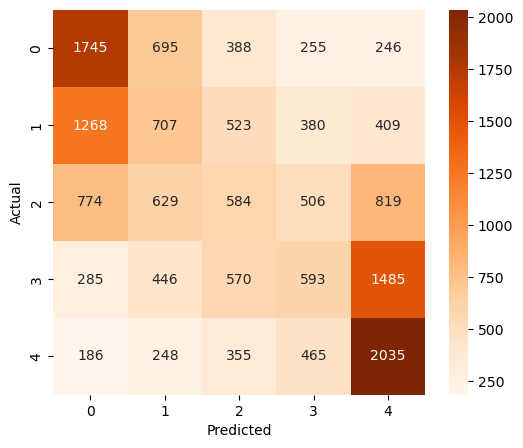

In [18]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt = 'd')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_pred_classes)
print('accuracy:', accuracy)
off_by_one = np.mean(np.abs(np.array(y_test) - np.array(y_pred_classes)) <= 1)
print('accuracy off-by-one:', off_by_one)
f1 = f1_score(y_test, y_pred_classes, average = 'macro')
print('f1 score:', f1)

accuracy: 0.34128705712219815
accuracy off-by-one: 0.7113159797541576
f1 score: 0.32059016584896155


In [20]:
for i in range(5):
    print(f'{i}:', (y_test == i).sum())

0: 3329
1: 3287
2: 3312
3: 3379
4: 3289


In [21]:
cnt = 0
sentiment_data = sentiment_data.sample(frac=1).reset_index(drop=True)
for idx, row in sentiment_data.iterrows():
    x = row[['pos', 'neu', 'neg']]
    x = np.asarray(x).astype('float32').reshape(1, -1)
    if((row['overall'] == 0 or row['overall'] == 4)and np.argmax(model.predict(x, verbose = 0)) == 2 and len(row['reviewText']) <= 200):
        cnt += 1
        print(f"text: {row['reviewText']}")
        print(f"predicted: {np.argmax(model.predict(x, verbose = 0))}")
        print(f"label: {row['overall']}")
        if(cnt == 10): break

text: My electrify M fits great with a Ballistic case attached. Gotta get a couple more. I carry concrete, blocks , lumber, plywood, sand, etc. and my phone never hits anything or goes to the floor.
predicted: 2
label: 4
text: hey dont get me wrong but i didnt buy this just so my iphone can be dipped in the water. i want to take underwater pics. but this plastic is cloudy and makes the pics blurry even when not underwater.
predicted: 2
label: 0
text: received the back door. it looks and feels oem as stated and is in great condition. received it fast and installed it no issues.
predicted: 2
label: 4
text: I bought the straight versions when I was using a Droid X.  With my Galaxy Nexus, these are a must have to use in the car and at work to keep the cord off to the side.
predicted: 2
label: 4
text: Phone came with a damaged screen. I live outside the US so now i have to accept my faith...Shame on you Amazon...
predicted: 2
label: 0
text: 
predicted: 2
label: 0
text: bought this for the w

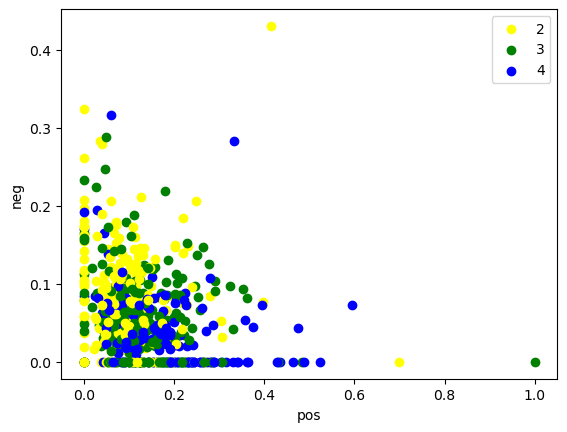

In [33]:
c = ['red', 'yellow', 'green', 'blue', 'black']
labels = {1: '2', 2: '3', 3: '4'}
plotted_labels = set()

for idx, row in sentiment_data.iterrows():
    if row['overall'] not in labels: continue
    label = labels[row['overall']]
    if label not in plotted_labels:
        plt.scatter(row['pos'], row['neg'], color=c[row['overall']], label=label)
        plotted_labels.add(label)
    else:
        plt.scatter(row['pos'], row['neg'], color=c[row['overall']])
    if idx > 1000: break

# Get handles and labels, then sort them
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

plt.legend(sorted_handles, sorted_labels, loc='upper right')
plt.xlabel("pos")
plt.ylabel("neg")
plt.show()


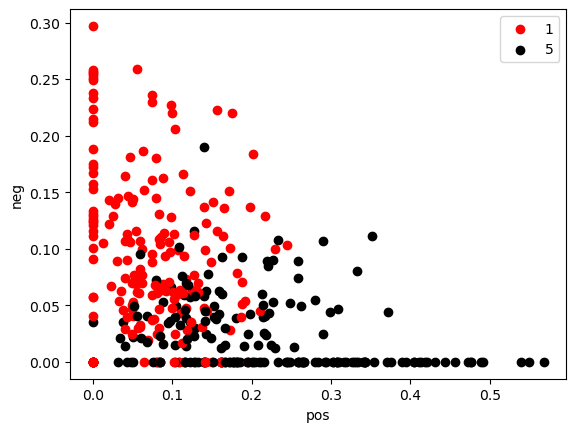

In [34]:
c = ['red', 'yellow', 'green', 'blue', 'black']
labels = {0: '1', 4: '5'}
plotted_labels = set()

for idx, row in sentiment_data.iterrows():
    if row['overall'] not in labels: continue
    label = labels[row['overall']]
    if label not in plotted_labels:
        plt.scatter(row['pos'], row['neg'], color=c[row['overall']], label=label)
        plotted_labels.add(label)
    else:
        plt.scatter(row['pos'], row['neg'], color=c[row['overall']])
    if idx > 1000: break

# Get handles and labels, then sort them
handles, labels = plt.gca().get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

plt.legend(sorted_handles, sorted_labels, loc='upper right')
plt.xlabel("pos")
plt.ylabel("neg")
plt.show()
